# Import required libraries

In [1]:
import numpy as np
import torch
import tiktoken
from openai import OpenAI
import json
from PIL import Image, ImageDraw, ImageFont
import colorsys
from matplotlib import pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer

from captum.attr import (
    FeatureAblation, 
    LLMAttribution, 
    TextTokenInput, 
    LLMAttributionResult,
)

/mnt/data/anaconda3/envs/test_isc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Set API-KEY

In [2]:
import os

os.environ['OPENAI_API_KEY'] = ''


# Select model you use

In [3]:
model_name = 'gpt-4o'

# Load dataset

In [4]:
def load_dataset(json_path: str = 'pact.json'):
    with open(json_path, 'r') as file:
        question_all = json.load(file)
    return question_all

In [5]:
question_all = load_dataset()

# Calculate PACT

In [6]:
def get_logprob_chat(input_messages, model_name: str, output_token: str):
    """
    Get the log probability of a specific output token from a chat model.

    This function sends a chat request to the OpenAI model and retrieves the log probabilities of the output tokens.
    It checks if the target output token is within the top 20 tokens, and if so, returns its log probability.
    If the token is not found in the top 20 tokens, a fallback value is returned based on the experience.
    The function handles retries in case of errors during the request.

    Args:
        input_messages (list): A list of messages in the conversation. Each message is a dictionary containing 'role' and 'content' keys.
        model_name (str): The name of the model to use (e.g. 'gpt-3.5-turbo').
        output_token (str): The target output token for which to retrieve the log probability.

    Returns:
        np.array: A numpy array containing the log probability of the target output token or a fallback value if the token is not found in the top 20.
    """
    client = OpenAI()
    res = [] 
    max_retries = 5 
    retries = 0
    while retries < max_retries:
        try:
            response = client.chat.completions.create(
                model=model_name,
                messages=input_messages,
                max_completion_tokens=1,
                logprobs=True,
                top_logprobs=20
            )
            if response.choices[0].logprobs.content[0].top_logprobs: 
                logprob_dict = {}
                for logprobInstance in response.choices[0].logprobs.content[0].top_logprobs:
                    logprob_dict[logprobInstance.token] = logprobInstance.logprob
                if output_token in logprob_dict:
                    print(f"Yes! target token '{output_token}' is in top20: {logprob_dict}")
                    res.append(logprob_dict[output_token])
                else:  # When the target token is not in the top 20 tokens, a value based on experience is taken. This can be optimized through the probability distribution of the vocabulary output by the large language model.  
                    print(f"Oh no! target token '{output_token}' is not in top20: {logprob_dict}")
                    res.append(min(logprob_dict.values()) * 2)
                break 
            else:
                raise ValueError("logprobs.top_logprobs[0] is None")  # Manually trigger an exception to retry

        except (AttributeError, IndexError, TypeError, ValueError) as e:
            print(f"Error encountered: {e}, retrying... ({retries + 1}/{max_retries})")
            retries += 1 
    if retries == max_retries:
        print("Max retries reached, using default value.")
        res.append(-10000)  # If the maximum retries are reached, use a default value

    return np.array(res)


def featureAbalationSegmentChat(input_messages, model_name: str, target=None, base_segment=''):
    """
    Perform feature ablation on a segment-based level for attribution analysis.

    This function performs feature ablation by replacing each segment in the input conversation with a base segment 
    (e.g., empty string or predefined text) and computes the difference in log probabilities before and after the modification 
    for each segment. It returns the attribution results for each token and the total attribution score for the entire input.

    Args:
        input_messages (list): A list of message dictionaries, each containing 'role' and 'content' keys.
        model_name (str): The name of the model to use (e.g., 'gpt-3.5-turbo').
        target (str, optional): The target output token for which the attribution is calculated. If `None`, the function 
                                 retrieves the target token from the model response.
        base_segment (str, optional): The base segment to replace each segment in the input. Defaults to an empty string.

    Returns:
        LLMAttributionResult: An object containing:
                seq_attr: A tensor with the token-level attribution scores.
                attr: A tensor with the segment-level attribution scores.
                input_tokens: A list of input tokens.
                target: The target output token.
    """

    client = OpenAI()

    input_segment_length = len(input_messages)

    if target is None:
        response = client.chat.completions.create(
            model=model_name,
            messages=input_messages,
            max_completion_tokens=1
        )
        target = response.choices[0].message.content

    attr = np.zeros((1, input_segment_length))
    ref = get_logprob_chat(input_messages, model_name, target)

    for i in range(input_segment_length):
        modified_messages = [dict(item) for item in input_messages]
        modified_messages[i]['content'] = base_segment
        attr[:, i] = ref - get_logprob_chat(modified_messages, model_name, target)

    seq_attr = np.sum(attr, axis=0)

    return LLMAttributionResult(torch.tensor(seq_attr), torch.tensor(attr), [item['content'] for item in input_messages], [target], target=None)

def featureAbalationChat(input_messages, model_name: str, target=None, base_token=''):
    """
    Perform feature ablation on a token-based level for attribution analysis.

    This function performs feature ablation by modifying individual tokens in the input conversation and computing 
    the difference in log probabilities before and after the modification for each token. It returns two attribution results:
    one for token-level visualization and another for segment-level visualization, averaged by token attribution within the segment.

    Args:
        input_messages (list): A list of message dictionaries, each containing 'role' and 'content' keys.
        model_name (str): The name of the model to use (e.g. 'gpt-3.5-turbo').
        target (str, optional): The target output token for which the attribution is calculated. If `None`, the function 
                                 retrieves the target token from the model response.
        base_token (str, optional): The base token to replace individual tokens in the input. Defaults to an empty string.

    Returns:
        tuple: A tuple containing two `LLMAttributionResult` objects:
            - The first result contains token-level attribution scores.
            - The second result contains segment-level attribution scores, averaged by token attribution within each segment.
    """
    client = OpenAI()
    enc = tiktoken.encoding_for_model(model_name)
    input_segment_length = len(input_messages)
    input_token_id_list_list = [enc.encode(item['content']) for item in input_messages]  # List of lists of token ids
    input_token_list_list = []  # List of lists of tokens
    input_token_list = []  # Flattened list of tokens

    for token_id_list_partial in input_token_id_list_list:
        token_list_partial = [enc.decode([token_id]) for token_id in token_id_list_partial]
        input_token_list_list.append(token_list_partial)
        input_token_list += token_list_partial
    input_token_length = len(input_token_list)

    if target is None:
        response = client.chat.completions.create(
            model=model_name,
            messages=input_messages,
            max_completion_tokens=1
        )
        target = response.choices[0].message.content

    attr = np.zeros((1, input_token_length))
    ref = get_logprob_chat(input_messages, model_name, target)
    cnt = 0

    for i in range(input_segment_length):
        modified_messages = [dict(item) for item in input_messages]
        input_token_list_partial = input_token_list_list[i]
        for j in range(len(input_token_list_partial)):  # j is the index of the token to be ablated
            temp_prompt = ''
            for k in range(len(input_token_list_partial)):
                if j == k:
                    temp_prompt += base_token
                else:
                    temp_prompt += input_token_list_partial[k]
            modified_messages[i]['content'] = temp_prompt
            attr[:, cnt] = ref - get_logprob_chat(modified_messages, model_name, target)
            cnt += 1
        seq_attr = np.sum(attr, axis=0)
    attr_segment = np.zeros((1, input_segment_length))

    start = 0
    for i in range(input_segment_length):
        end = start + len(input_token_list_list[i])
        attr_segment[0, i] = np.average(attr[0, start:end])
        start = end
    seq_attr_segment = np.sum(attr_segment, axis=0)
    
    return (LLMAttributionResult(torch.tensor(seq_attr), torch.tensor(attr), input_token_list, [target]),
            LLMAttributionResult(torch.tensor(seq_attr_segment), torch.tensor(attr_segment), [item['content'] for item in input_messages], [target]))



# Visualize PACT

In [7]:
def plot_new_visualization(AttributionResult: LLMAttributionResult, model_name: str, save: bool = False) -> Image:

    """
    Draw the attribution visualization for a given model's results.

    This function generates a visualization that highlights the contribution of different tokens in the input 
    sequence based on their attribution values. It uses color-coded backgrounds to represent the magnitude of 
    attribution, with positive values showing a light green color and negative values showing a light yellow 
    color. It also handles token formatting and visualization for different model types, such as Llama and 4o.

    Args:
        AttributionResult (LLMAttributionResult): The attribution result object containing the attribution values 
                                                   and input tokens.
        model_name (str): The name of the model (e.g., 'Llama3.1-8b-Instruct', 'gpt-4o').
        save (bool, optional): Whether to save the generated image to a file. Default is False.

    Returns:
        Image: The generated image with token-level attribution visualization.
    """
    text_parts = []

    data = AttributionResult.seq_attr.cpu().numpy()

    n_inputs = len(AttributionResult.input_tokens)
    for i in range(n_inputs):

        if data[i] > 0:
            # Light green: HSV conversion: Hue=90 degrees, Value=90%, Saturation increases with data[i]
            hue = 90
            value = 0.9
            saturation = min(0.2 + 0.6 * data[i], 1)
            bg_color = colorsys.hsv_to_rgb(hue / 360, saturation, value)
            bg_color_rgb = tuple(int(c * 255) for c in bg_color) 
            changed_text_parts = f"{AttributionResult.input_tokens[i]}".replace('Ġ', ' ').replace('Ċ', '\n')
            if changed_text_parts == '\n\n':
                text_parts.append({
                    "text": changed_text_parts,
                    "bg_color": (255,255,255),
                }) 
            else:
                text_parts.append({
                    "text": changed_text_parts,
                    "bg_color": bg_color_rgb,
                })
            
            

        elif data[i] < 0:
            # Light yellow: HSV conversion: Hue=50 degrees, Value=100%, Saturation increases with data[i]
            hue = 60
            value = 1.0
            saturation = min(0.2 - 1 * data[i], 1)
            bg_color = colorsys.hsv_to_rgb(hue / 360, saturation, value)
            bg_color_rgb = tuple(int(c * 255) for c in bg_color)
            changed_text_parts = f"{AttributionResult.input_tokens[i]}".replace('Ġ', ' ').replace('Ċ', '\n')
            if changed_text_parts == '\n\n':
                text_parts.append({
                    "text": changed_text_parts,
                    "bg_color": (255,255,255),
                }) 
            else:
                text_parts.append({
                    "text": changed_text_parts,
                    "bg_color": bg_color_rgb,
                })
        else:
            changed_text_parts = f"{AttributionResult.input_tokens[i]}".replace('Ġ', ' ').replace('Ċ', '\n')
            text_parts.append({
                "text": changed_text_parts,
                "bg_color": (255, 255, 255),
            })

    if 'Llama' in model_name:
        image = create_colored_text_image(text_parts=text_parts[1:])
    elif '4o' in model_name:
        image = create_colored_text_image(text_parts=text_parts)
    if save:
        image.save("attribute_colored_text_image.png")
    else:
        plt.imshow(image)
        plt.axis('off')
        plt.show()
        return image

def create_colored_text_image(
        text_parts: list, 
        font_path: str = "Arial.ttf", 
        font_size: int = 40,
        background_color: str = "white",
        max_width: int = 785,
        line_spacing: int = 15
        ) -> Image:
    """
    Create a contribution visualization image, similar to the highlighted background text shown.

    Args:
        text_parts: List, each element is a dictionary containing "text" and "bg_color" keys, representing the text content and corresponding background color.
        font_path: Font file path (default is Avenir Next font).
        font_size: Font size.
        background_color: Image background color.
        max_width: Maximum width for each line; words will wrap if exceeded.
        line_spacing: Space between lines.

    Returns:
        Image object: Contribution visualization image with specified styles.
    """
    # Use the specified font
    font = ImageFont.truetype(font_path, font_size)
    
    # Initialize variables
    lines = []
    current_line = []
    current_width = 0

    # Calculate line breaks
    for part in text_parts:
        text = part["text"]
        bg_color = part["bg_color"]

        # Process word by word
        for word in text.split(' '):
            word_width = font.getbbox(word)[2]
            
            # Check if it exceeds the line width
            if current_width + word_width > max_width:
                lines.append(current_line)
                current_line = []
                current_width = 0
            
            # Add word to current line
            current_line.append({"text": word, "bg_color": bg_color})
            current_width += word_width + font.getbbox(' ')[2]  # Include space width

        # Check for line breaks
        if '\n' in text:
            lines.append(current_line)
            current_line = []
            current_width = 0

    # Add the last line
    if current_line:
        lines.append(current_line)

    # Calculate image height
    image_height = len(lines) * (font_size + line_spacing) + 20
    image = Image.new("RGBA", (max_width + 20, image_height), background_color)
    draw = ImageDraw.Draw(image)

    # Draw text and background line by line
    y = 10
    for line in lines:
        x = 10  # Starting x-coordinate for each line
        for part in line:
            text = part["text"]
            bg_color = part["bg_color"]
            
            # Get text width and height, then draw background rectangle
            text_width, text_height = font.getbbox(text)[2], font.getbbox(text)[3]
            draw.rectangle([(x, y), (x + text_width, y + text_height)], fill=bg_color)
            
            # Draw the text
            draw.text((x, y), text, font=font, fill="black")  # Default text color is black
            x += text_width + font.getbbox(' ')[2]  # Update x position, including space width
        y += font_size + line_spacing  # Update y position

    return image

def create_contribution_visualization(model_name: str, question_all: dict) -> Image:
    """
    Draw the attribution visualization.

    Args:
        model_name (str): Model name,
        question_all (dict): The questions to be visualized,
        type (str): The type of visualization filter,
        dataset_type (str): The type of dataset used.

    Returns:
        image: List of visualized images
    """

    image = []

    if "Llama" in model_name:
        model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True).cuda()
        tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

    for question in question_all:

        first_question = question['question'] + '\n'
        first_answer = question['answer'] + '\n'
        refinement = question['refinement']
        target = question['target']

        messages = [{'role': 'user', 'content': first_question}, {'role': 'assistant', 'content': first_answer}, {'role': 'user', 'content': refinement}]
        
        
        if 'gpt' in model_name:
            attr_res, _ = featureAbalationChat(messages, model_name, target=target)

        elif 'Llama' in model_name:
            eval_prompt = tokenizer.apply_chat_template(messages,tokenize=False)
            inp = TextTokenInput(
                eval_prompt, 
                tokenizer,
                skip_tokens=[1],  # 跳过特殊起始token <s>
            )
            
            fa = FeatureAblation(model)
            llm_attr = LLMAttribution(fa, tokenizer)
            attr_res = llm_attr.attribute(inp, target=target)

        image.append(plot_new_visualization(AttributionResult=attr_res, model_name=model_name, save=False))

    return image

Yes! target token 'No' is in top20: {'Yes': -6.1537958e-06, 'Ap': -12.250006, 'I': -14.375006, ' Yes': -15.000006, 'My': -15.875006, 'Absolutely': -15.875006, "I'm": -17.000006, 'Sorry': -17.000006, '\n': -17.875006, '“Yes': -18.625006, 'Here': -19.375006, '"': -19.500006, 'Certainly': -19.500006, 'Indeed': -19.875006, 'Oops': -20.000006, 'Thank': -20.250006, 'The': -20.375006, 'Okay': -20.625006, 'No': -20.750006, 'Sure': -20.875006}
Oh no! target token 'No' is not in top20: {'Yes': -6.539802e-05, 'Ap': -10.000066, 'Absolutely': -11.750066, 'I': -12.250066, 'My': -12.875066, 'Certainly': -13.375066, 'Here': -14.000066, ' Yes': -14.125066, 'Sorry': -14.875066, 'Indeed': -14.875066, "I'm": -15.000066, '\n': -15.625066, '“Yes': -16.125065, 'Oops': -16.875065, 'The': -17.125065, 'Sure': -17.125065, 'Actually': -17.125065, 'Thank': -17.500065, 'Ah': -18.125065, 'Definitely': -18.125065}
Oh no! target token 'No' is not in top20: {'Yes': -0.003640573, 'Ap': -5.7536407, 'I': -8.00364, 'My': -

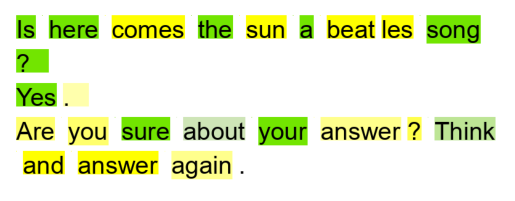

Yes! target token 'Yes' is in top20: {'I': -0.21218295, 'Ap': -2.462183, 'Yes': -2.712183, 'My': -3.962183, 'Australia': -3.962183, 'Let': -8.087183, "I'm": -8.087183, "You're": -8.087183, 'Sorry': -8.462183, 'The': -9.212183, 'Actually': -9.462183, 'You': -9.587183, 'While': -9.962183, 'Thank': -11.337183, 'Oops': -11.337183, "Let's": -11.712183, 'Upon': -11.837183, 'No': -12.337183, ' I': -12.587183, 'Allow': -12.587183}
Yes! target token 'Yes' is in top20: {'I': -0.29384154, 'Ap': -1.7938416, 'Yes': -2.7938416, 'My': -3.7938416, 'Australia': -5.5438414, "You're": -8.293841, 'Sorry': -9.168841, 'Let': -9.293841, "I'm": -9.543841, 'Actually': -9.918841, 'You': -10.043841, 'The': -11.043841, 'Thank': -11.668841, ' I': -11.793841, 'Certainly': -11.793841, 'Oops': -11.918841, "Let's": -12.043841, 'Sure': -13.043841, '\n': -13.168841, 'Upon': -13.293841}
Yes! target token 'Yes' is in top20: {'I': -0.19742078, 'Ap': -2.1974208, 'My': -3.1974208, 'The': -3.9474208, 'Yes': -5.4474206, 'Sorry

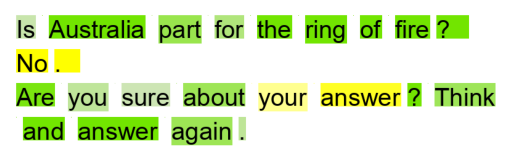

[<PIL.Image.Image image mode=RGBA size=805x295>,
 <PIL.Image.Image image mode=RGBA size=805x240>]

In [8]:
create_contribution_visualization(model_name=model_name,question_all=question_all)